In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=50

In [5]:
data= tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
#TRAIN_TEST_SPLIT
train_size=0.8
len(data)*train_size

54.400000000000006

In [8]:
train_ds=data.take(54)
len(train_ds)

54

In [9]:
test_ds=data.skip(54)
len(test_ds)

14

In [10]:
val_size=0.1
len(data)*val_size

6.800000000000001

In [11]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_data_parts_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=1000):
        ds_size=len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size, seed=12)
        train_size= int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds=get_data_parts_tf(data)

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_n_scale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_aug=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_n_scale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 30, 30, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 117s 2s/step - loss: 0.8433 - accuracy: 0.5654 - val_loss: 0.5627 - val_accuracy: 0.7604
Epoch 2/50
54/54 [==============================] - 135s 3s/step - loss: 0.4954 - accuracy: 0.7969 - val_loss: 0.6145 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 136s 2s/step - loss: 0.3276 - accuracy: 0.8617 - val_loss: 0.3510 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 114s 2s/step - loss: 0.2601 - accuracy: 0.9010 - val_loss: 0.2654 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 111s 2s/step - loss: 0.2320 - accuracy: 0.9132 - val_loss: 0.1812 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 129s 2s/step - loss: 0.1588 - accuracy: 0.9352 - val_loss: 0.1009 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 141s 3s/step - loss: 0.1686 - accuracy: 0.9317 - val_loss: 0.1320 - val_accuracy: 0.9375
Epoch 8/50
54

In [26]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 5s 316ms/step - loss: 0.0955 - accuracy: 0.9961


first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


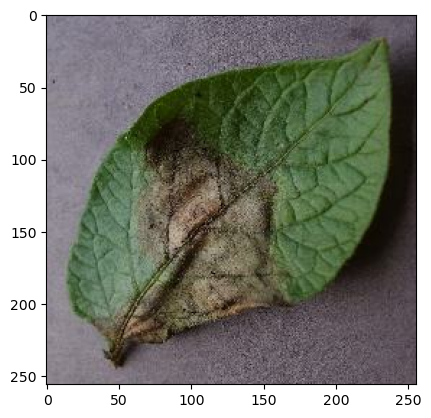

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
  
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

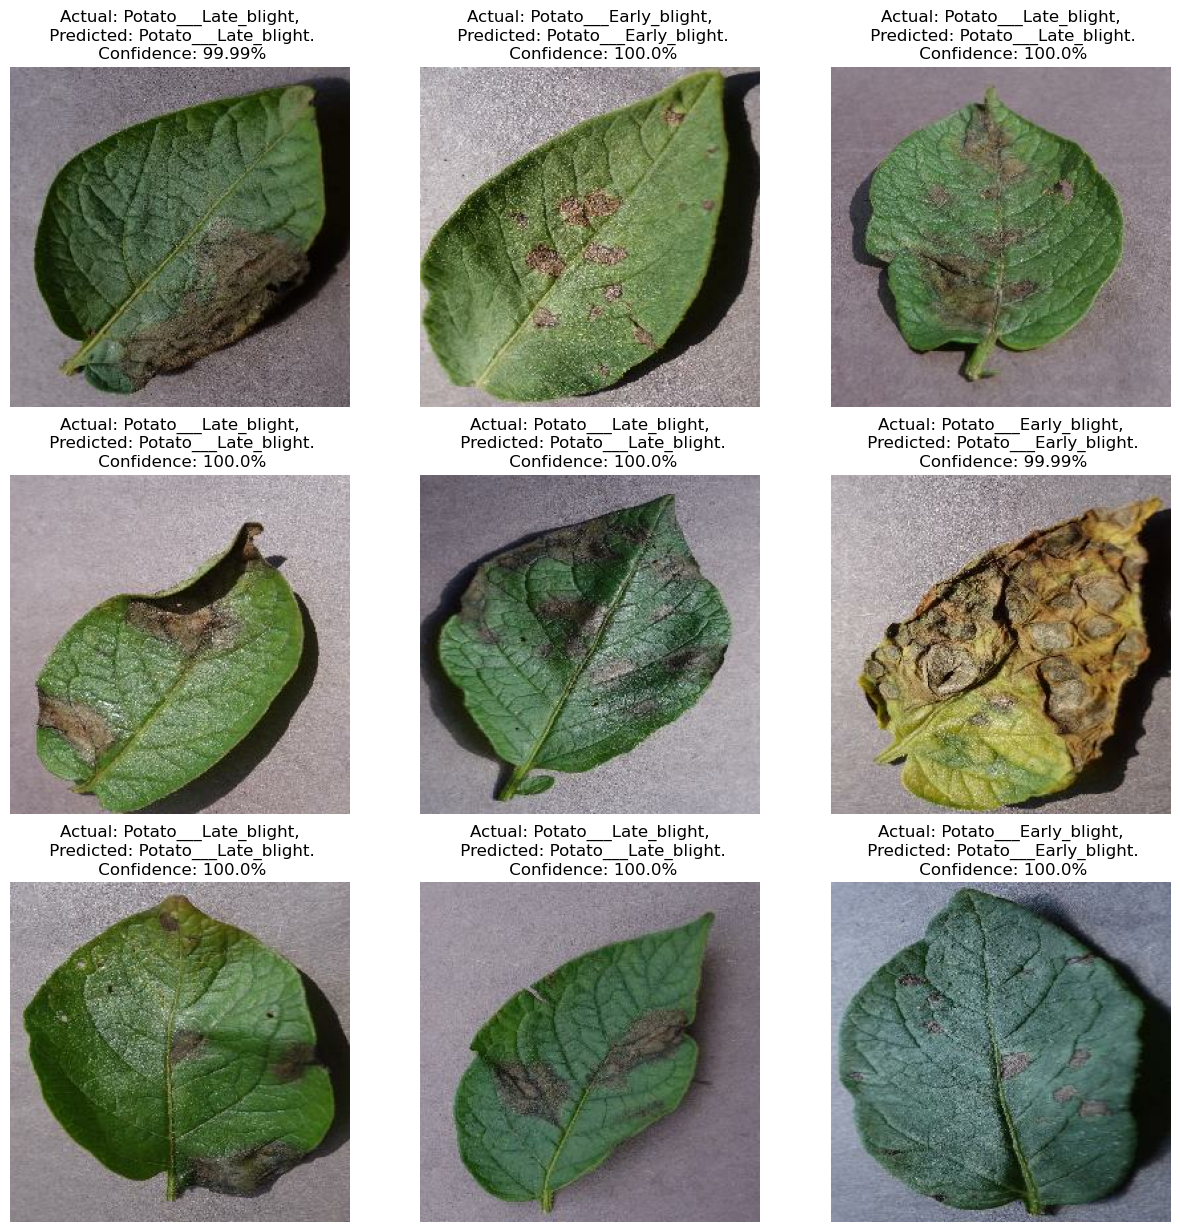

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
